In [2]:
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor, DMatrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error
import pickle

In [3]:
params = {'legend.fontsize': 14,
         'axes.labelsize': 16,
         'axes.titlesize': 16,
         'xtick.labelsize': 10,
         'ytick.labelsize': 10}
plt.rcParams.update(params)

In [4]:
## Create file paths to use. Change to the 'Datasets directory'
initial_dir = os.getcwd()
data_folder = os.path.join(os.getcwd(), 'Datasets')
data_path = os.path.join(data_folder, "data")

In [5]:
# Import the datasets we exported from the data prep notebook. Drop the 'dateRep' column.
train_X = pd.read_csv(os.path.join(data_path, "train", 'train_x.csv'), index_col=0).drop(columns=['dateRep'])
train_y = pd.read_csv(os.path.join(data_path, "train", 'train_y.csv'), index_col=0).drop(columns=['dateRep'])

df_x = pd.read_csv(os.path.join(data_path, "test", 'test_x.csv'), index_col=0).drop(columns=['dateRep'])
df_y = pd.read_csv(os.path.join(data_path, "test", 'test_y.csv'), index_col=0)

In [6]:
params = {'max_depth':[5, 10, 15],
          'eta': [0.1, 0.2, 0.3, 0.5],
          'n_estimators': [50, 100, 200],
          'min_child_weight':[1, 2, 3, 5],
          'gamma': [1, 2, 3, 5]}

In [7]:
xgbr = XGBRegressor(objective="reg:squarederror",
                    eval_metric='mae',
                    num_round=30,
                    silent = 0)

In [8]:
model = GridSearchCV(estimator=xgbr,
                     param_grid=params,
                     scoring='neg_mean_absolute_error',
                     cv=10,
                     verbose=1,
                     n_jobs=-1)

In [9]:
# Train the model. Can take > 10 minutes.
# Remove quote marks if you want to run the model.
"""model.fit(train_X.values, train_y.values)"""

'model.fit(train_X.values, train_y.values)'

In [10]:
"""model_path = os.path.join(data_folder, "model")
# Check if the directory exists.
# Skip this cell if you didn't run the model.
if os.path.exists(model_path) is False:
    os.mkdir(model_path)
# Export the computed model for quick import again later.
pickle.dump(model, open(os.path.join(model_path, "xgb.pkl"), "wb"))"""

'model_path = os.path.join(data_folder, "model")\n# Check if the directory exists.\n# Skip this cell if you didn\'t run the model.\nif os.path.exists(model_path) is False:\n    os.mkdir(model_path)\n# Export the computed model for quick import again later.\npickle.dump(model, open(os.path.join(model_path, "xgb.pkl"), "wb"))'

In [11]:
model_path = os.path.join(data_folder, "model")
# This code is to import the ready made model, remove the '#' symbol on the line below to import it.
model = pickle.load(open(os.path.join(model_path, "xgb.pkl"), "rb"))

In [11]:
# Concatenate together the test x and y dataframes
df = pd.concat([df_x, df_y], axis=1)
# Merge the train X and y dataframes
df1 = train_X.merge(train_y, left_index=True, right_index=True)

In [12]:
# Predicting the daily deaths for each country using our model
y_pred = model.predict(df_x.values) # model.predict(df_x[train_X.columns].values)
df["deaths_pred"] = y_pred
# Computing the model error
df["model_error"] = df["deaths"] - df["deaths_pred"]

In [13]:
print(f"XGBoost MAE score: {np.round(mean_absolute_error(df.deaths, df.deaths_pred))}")
print(f"XGBoost R2 score: {np.round(r2_score(df.deaths, df.deaths_pred), 4)}")

XGBoost MAE score: 120.0
XGBoost R2 score: 0.7372


In [14]:
# Append df and df1 so that we now have the complete dataframe again
df = df.append(df1)
# Import in the covid19_df from the data prep stage for a full comparison to the predictions
df_global = pd.read_csv(os.path.join(data_folder, "Data_Export", "covid19_df.csv"), index_col=0)
# Merge the df_global dataframe with the predicted deaths and model error columns we created
df_global = df_global.merge(df[['deaths_pred', 'model_error']], left_index=True, right_index=True)
# Calculate the cumulative error in the model for each country using a 'groupby'
df_global['cumulative_error'] = df_global.groupby('countriesAndTerritories')['model_error'].cumsum()
# Recreate the top_count list using the line below
top_count = list(df_global.groupby('countriesAndTerritories')['deaths'].sum().sort_values(ascending=False).iloc[:20].keys())

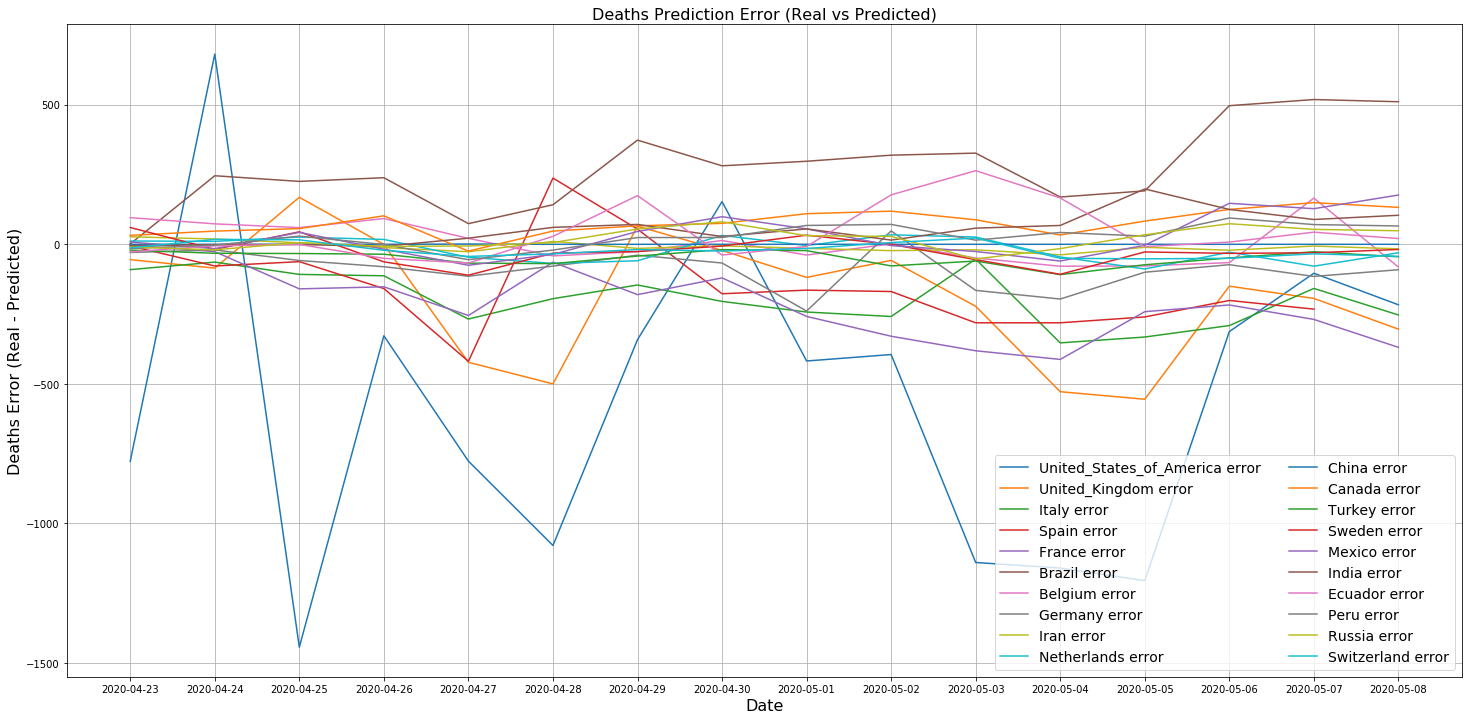

In [15]:
#plt.style.use('classic')
# Visualising the Linear Regression results
plt.figure(figsize=(25, 12))
for country in top_count:
    plt.plot(df_global[df_global["countriesAndTerritories"] == country]["dateRep"],
             df_global[df_global["countriesAndTerritories"] == country]['model_error'], label=f"{country} error")
plt.title('Deaths Prediction Error (Real vs Predicted)')
plt.xlabel('Date')
plt.ylabel('Deaths Error (Real - Predicted)')
plt.grid()
plt.legend(ncol=2)
plt.show()

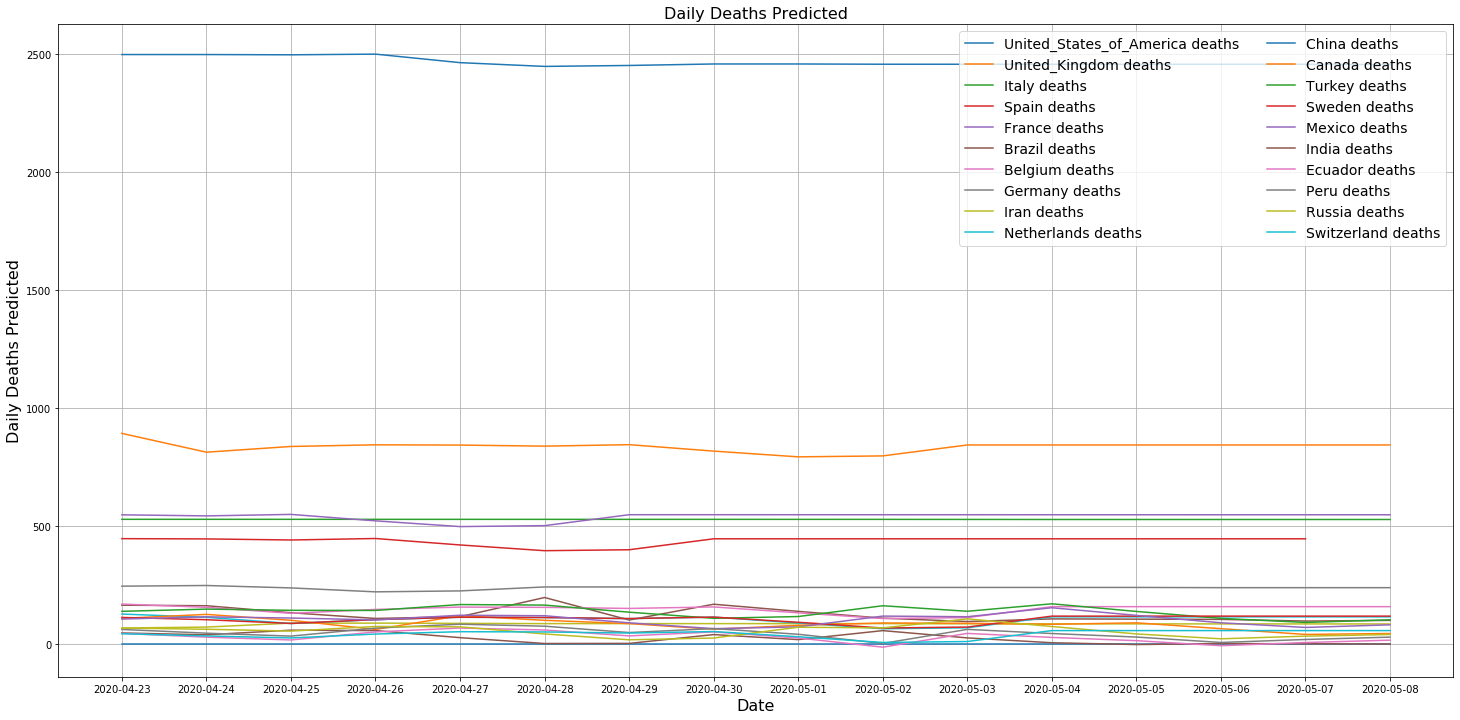

In [16]:
# Visualising the Linear Regression results
plt.figure(figsize=(25, 12))
for country in top_count:
    plt.plot(df_global[df_global["countriesAndTerritories"] == country]["dateRep"],
             df_global[df_global["countriesAndTerritories"] == country]['deaths_pred'], label=f"{country} deaths")
plt.title('Daily Deaths Predicted')
plt.xlabel('Date')
plt.ylabel('Daily Deaths Predicted')
plt.grid()
plt.legend(ncol=2)
plt.show()

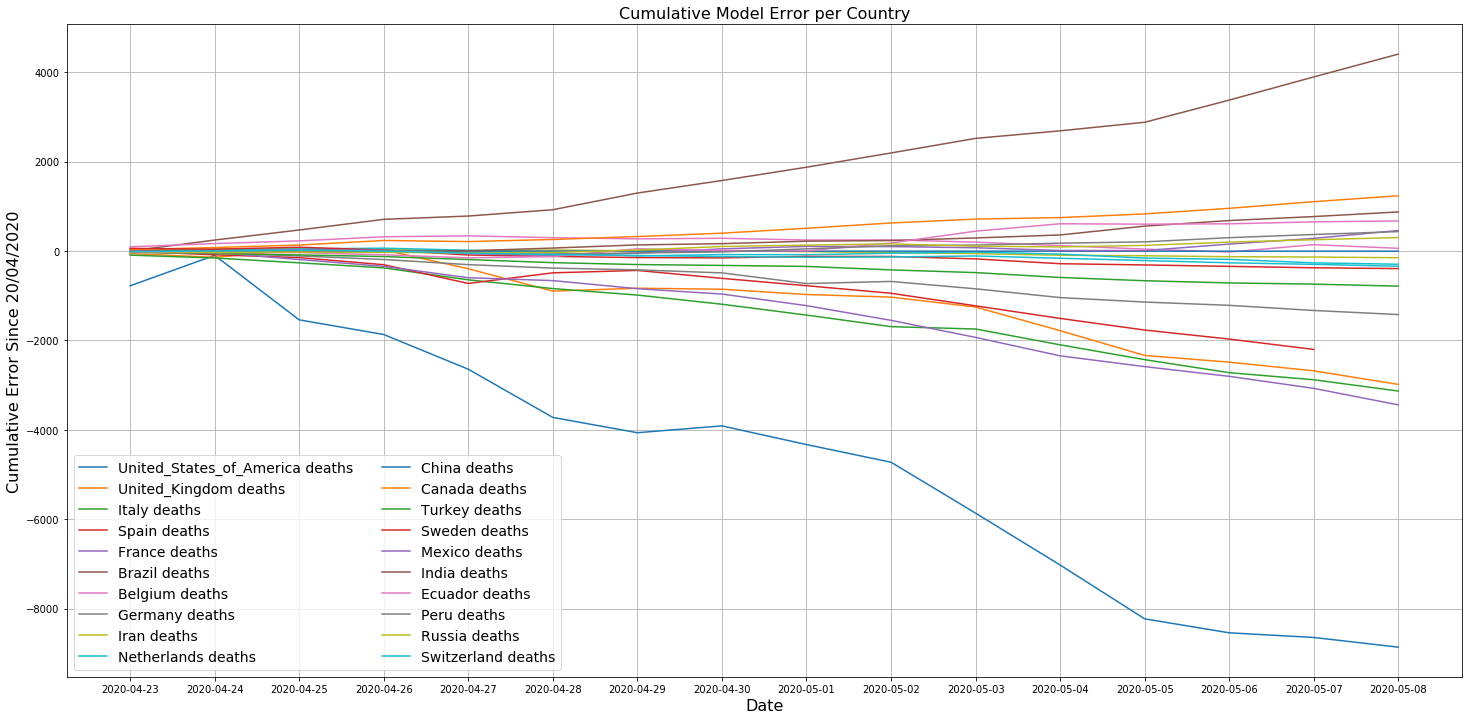

In [17]:
# Visualising the Linear Regression results
plt.figure(figsize=(25, 12))
for country in top_count:
    plt.plot(df_global[df_global["countriesAndTerritories"] == country]["dateRep"],
             df_global[df_global["countriesAndTerritories"] == country]['cumulative_error'], label=f"{country} deaths")
plt.title('Cumulative Model Error per Country')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Cumulative Error Since 20/04/2020')
plt.grid()
plt.legend(ncol=2)
#plt.savefig('cumulative_error_20_countries_XGB_dpi300.jpeg', dpi=300)

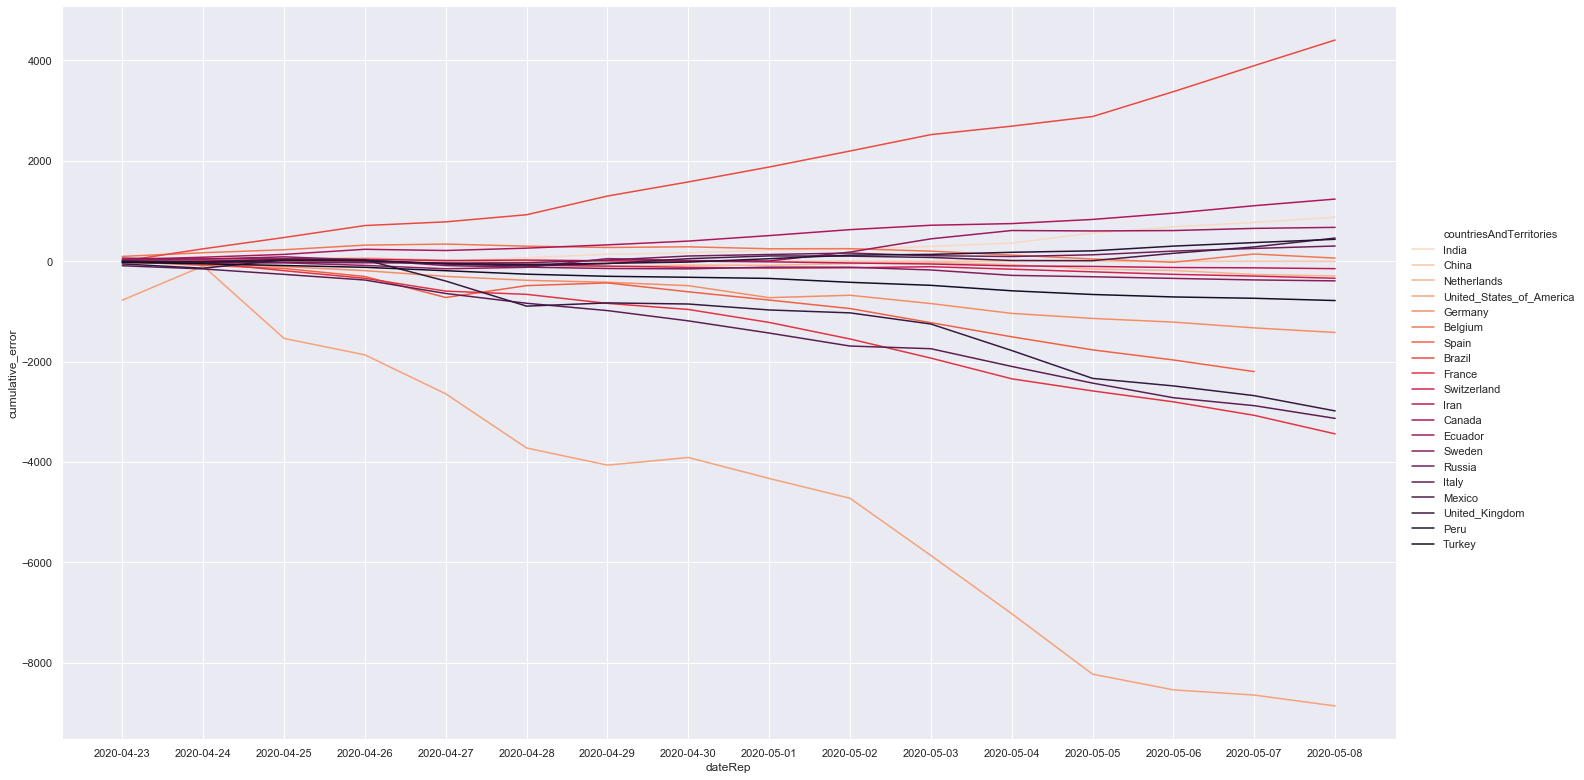

In [18]:
# Define a palette to ensure that colors will be
# shared across the facets
#sns.set_context(font_scale=101.5)
palette = dict(zip(df_global.countriesAndTerritories.unique(),
                   sns.color_palette("rocket_r", len(top_count))))
sns.set(rc={'figure.figsize':(12,9)}) #,font_scale=1.8)
# Plot the lines
g = sns.relplot(x="dateRep", y="cumulative_error",
            hue="countriesAndTerritories", palette=palette,
            height=11, aspect=1.8, facet_kws=dict(sharex=False),
            kind="line", legend="full", data=df_global)
#plt.savefig('residual_deaths_20_countries_XGB_dpi300.jpeg', dpi=300)

In [19]:
if os.path.exists(os.path.join(data_folder, "model_predictions")) is False:
    os.mkdir(os.path.join(data_folder, "model_predictions"))
df_global.to_csv(os.path.join(data_folder, "model_predictions", "xgb_predictions.csv"))

Text(0.5, 0, 'Prediction error (m)')

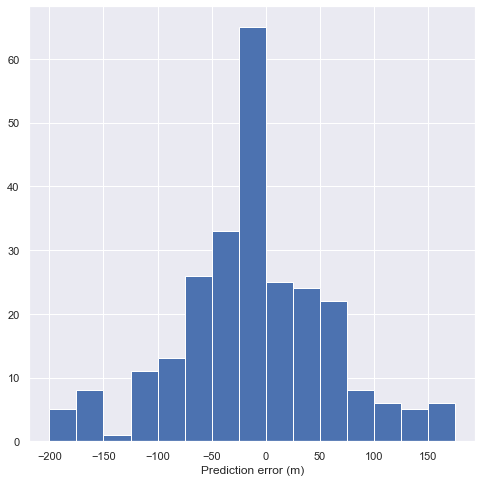

In [20]:
#plt.style.use('ggplot')
plt.figure(figsize=(8, 8))
plt.hist(df["model_error"], bins=np.arange(-200, 200,25))
plt.xlabel("Prediction error (m)")
#plt.show()

Text(0, 0.5, 'predicted Deaths')

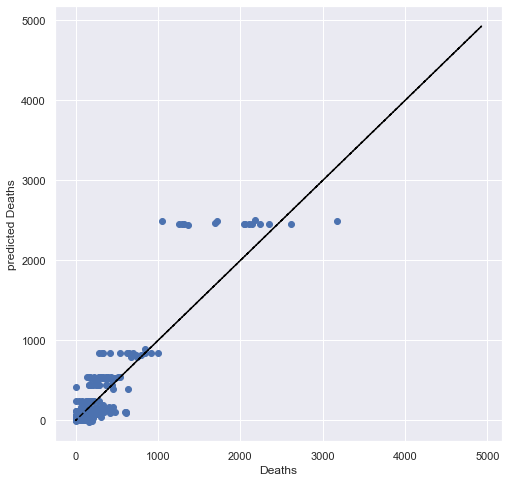

In [21]:
plt.figure(figsize=(8, 8))
plt.scatter(df.deaths, df.deaths_pred)
plt.plot(df.deaths, df.deaths, color="black", linestyle="--")
plt.xlabel("Deaths")
plt.ylabel("predicted Deaths")
#plt.show()